# Benchmarking Multiphase Monte Carlo Sampling

# Motivation

As a methods researcher one is often interested in testing new methods and benchmarking them together with state-of-the-art algorithms.
hopsy provides the framework for conducting such comparisons, because it allows the methods researcher to focus on the algorithms, while the scaffolding, i.e., I/O, convergence diagnostics, and state-of-the-art implementations of existing algorithms are provided.


We show in this notebook how one can adapt build a multiphase monte carlo sampling plugin for hopsy

## Background
Instead of rounding before sampling, multiphase monte carlo sampling rounds adaptively based on the samples of the Markov chain during a run.
It has been reported to be an efficient strategy, if the underlying Markov chain is efficient enough.

The Idea has found previous adaption in the artificially centered coordinate hit-and-run and the optGP sampler.
However, Coordinate Hit-and-Run Rounded showed greater and more stable performance (https://pubmed.ncbi.nlm.nih.gov/28158334/) than both of those algorithms.

The idea is resurrected and shown to be efficient given a better Markov chain implementation.
See https://drops.dagstuhl.de/opus/volltexte/2021/13820/pdf/LIPIcs-SoCG-2021-21.pdf

In [181]:
import arviz
import hopsy
from matplotlib import pyplot as plt
import numpy as np
from typing import List
import time
import PolyRound

In [188]:
# rounding based on samples, as suggested in https://drops.dagstuhl.de/opus/volltexte/2021/13820/pdf/LIPIcs-SoCG-2021-21.pdf 
def svd_rounding(samples, problem):
    # We concatenate them samples to [n_dim, n_iterations] for rounding
    print("A", problem.A.shape)
    print("b", problem.b.shape)
    print("T", problem.transformation.shape)
    print("shift", problem.shift.shape)
    print("samples", samples.shape)
    stacked_samples = np.concatenate(samples, axis=0)
    print('s', stacked_samples.shape)
    stacked_samples = hopsy.transform(problem, [stacked_samples[i,:].flatten() for i in range(stacked_samples.shape[0])])
    print("s'", stacked_samples.shape)
    U, S, Vh = np.linalg.svd(stacked_samples)
    # Rescaling as mentioned in  https://drops.dagstuhl.de/opus/volltexte/2021/13820/pdf/LIPIcs-SoCG-2021-21.pdf
    s_ratio = np.max(S) / np.min(S)
    S = S / np.min(S)
    if np.max(S) >= 2.0 :
        S[np.where(S > 2.0)] = 2.
    rounding_matrix = Vh.dot(np.diag(S))

    # We do not want to use all transforms to transform the mcmc state space. Instead we use only the one from the current iteration
    sub_problem = hopsy.Problem(problem.A,  problem.b, transformation=rounding_matrix)
    starting_points = hopsy.transform(sub_problem, [samples[i, -1, :] for i in range(samples.shape[0])])
    
    print("A", problem.A.shape)
    print("R", rounding_matrix.shape)
    problem.A = problem.A.dot(rounding_matrix)
    problem.transformation = rounding_matrix if problem.transformation is None else problem.transformation.dot(rounding_matrix )
    
    return s_ratio, starting_points, problem

In [189]:
# creating a custom proposal to plug in to hopsy, in this case based on https://ui.adsabs.harvard.edu/abs/2015IJMPC..2650010D/abstract
class OverrelaxedHitAndRunProposal:
    def __init__(self, problem: hopsy.Problem, starting_point: np.ndarray, epsilon: float=1e-10):
        self.A = problem.A
        self.b = problem.b
        self.state = starting_point
        self.proposal = self.state
        self.epsilon = epsilon
        
    def propose(self, rng) -> np.ndarray:
        """This method is called by hopsy.MarkovChain. Returns the proposal"""
        direction = np.random.randn(self.state.shape[0])
        direction /= np.linalg.norm(direction, axis=0)
        
        inverse_distances = np.nan_to_num(np.divide(self.A@direction, self.b-self.A@self.state, self.A@direction))
        forward_distance = 1. / np.max(inverse_distances)
        backward_distance = 1. / np.min(inverse_distances)
        
        L = forward_distance - backward_distance
        a = 2*(-backward_distance) / L - 1
        if a == 0:
            a = self.epsilon
        t_1 = L * (1 + a - np.sqrt((1 + a) ** 2  - 4 * a * np.random.uniform())) / (2 * a);
        t_0 = -backward_distance;
        
        self.proposal = self.state + (t_1 - t_0) * direction;
        return self.proposal

In [190]:
def run_multiphase_sampling(proposal, problem: hopsy.Problem, seeds: List, target_ess: float, steps_per_phase: int, starting_points: List):
    limit_singular_ratio_value = 3  # from https://drops.dagstuhl.de/opus/volltexte/2021/13820/pdf/LIPIcs-SoCG-2021-21.pdf
    assert(len(starting_points) == len(seeds))
    rngs = [hopsy.RandomNumberGenerator(s) for s in seeds]

    ess = 0
    iterations = 0
    s_ratio = limit_singular_ratio_value + 1
    sampling_time = 0
    while ess < target_ess:
        iterations += 1
        markov_chains = [hopsy.MarkovChain(problem, proposal, starting_point=s) for s in starting_points]

        start = time.time()
        acceptance_rate, _samples = hopsy.sample(markov_chains, rngs, n_samples=steps_per_phase, thinning=1, n_procs=1)
        end = time.time()
        sampling_time += end-start
        print('\titer:', iterations)

        if s_ratio > limit_singular_ratio_value:
            # also measures the rounding time
            start = time.time()
            s_ratio, starting_points, problem = svd_rounding(_samples, problem)
            end = time.time()
            sampling_time += end-start
            print('\ts_ratio:', s_ratio)
            samples = _samples
        else:
            print('\tno adaptive rounding')
            samples = np.concatenate((samples, _samples), axis=1)
            starting_points =  samples[:, -1, :]
            
        ess = np.min(hopsy.ess(samples))
        print('\tess', str(ess) + ',', 'samples', samples.shape[1])

    return samples, iterations, ess, sampling_time


def run_sampling(proposal, problem: hopsy.Problem, seeds: List, target_ess: float, steps_per_phase: int, starting_points: List, thinning=None):
    rngs = [hopsy.RandomNumberGenerator(s) for s in seeds]

    thinning = thinning if thinning is not None else int(float(problem.A.shape[1]**2)/6)
    ess = 0
    iterations = 0
    # also measures the rounding time
    start = time.time()
    rounded_problem = hopsy.round(problem)
    end = time.time()
    sampling_time = end - start
    samples = None
    markov_chains = [hopsy.MarkovChain(problem=rounded_problem, starting_point=s) for s in starting_points]
    while ess < target_ess:
        iterations += 1
        print('\titer:', iterations)
        for i in range(len(starting_points)):
            markov_chains[i].proposal = proposal(rounded_problem, starting_point=starting_points[i])
        
        start = time.time()
        acceptance_rate, _samples = hopsy.sample(markov_chains, rngs, n_samples=steps_per_phase, thinning=thinning, n_procs=1)
        end = time.time()
        sampling_time += end-start

        samples = _samples if samples is None else np.concatenate((samples, _samples), axis=1)
        starting_points =  hopsy.transform(rounded_problem, samples[:, -1, :])
            
        ess = np.min(hopsy.ess(samples))
        print('\tess', str(ess) + ',', 'samples', samples.shape[1])

    return samples, iterations, ess, sampling_time

In [191]:
# general parameters
target_ess = 1000
proposalTypes = {
    "Billiard walk": hopsy.BilliardWalkProposal, 
    "CHRRT": hopsy.UniformCoordinateHitAndRunProposal,
#     "OHRR": OverrelaxedHitAndRunProposal,
}

seeds = [1, 2, 3, 4]

def generate_problem(name):
    if name == "BP5":
        bp = hopsy.BirkhoffPolytope(5)
        problem = hopsy.Problem(bp.A, bp.b)
        return problem
    elif name == "e_coli":
        polytope = PolyRound.static_classes.parse_sbml_stoichiometry.StoichiometryParser.parse_sbml_cobrapy('../extern/hops/resources/e_coli_core/e_coli_core.xml')
        problem = hopsy.add_equality_constraints(hopsy.Problem(polytope.A, polytope.b), polytope.S, polytope.h)
        return problem

In [192]:
samples = {}
iterations = {}
ess = {}
times = {}
ess_t = {}

for name, p in proposalTypes.items():
    print('running benchmark for', name)
    # resets problem and starting points
    problem = generate_problem('e_coli')
    steps_per_phase = problem.A.shape[1] * 20
    cheby = hopsy.compute_chebyshev_center(problem).flatten()
    starting_points = [cheby for s in seeds]

    if name == "Billiard walk":
        samples[name], iterations[name], ess[name], times[name] = run_multiphase_sampling(proposal=p, problem=problem, seeds=seeds, target_ess=target_ess, steps_per_phase=steps_per_phase, starting_points=starting_points)
    else: 
        thinning = 1 if name != 'CHRRT' else max(int(float(problem.A.shape[1]**2)/6), 1)
        samples[name], iterations[name], ess[name], times[name] = run_sampling(proposal=p, problem=problem, seeds=seeds, target_ess=target_ess, steps_per_phase=steps_per_phase, starting_points=starting_points, thinning=thinning)
    ess_t[name] = ess[name] / times[name]

running benchmark for Billiard walk
	iter: 1
A (36, 24)
b (36,)
T (95, 24)
shift (95,)
samples (4, 480, 95)
s (1920, 95)


LinAlgError: Last 2 dimensions of the array must be square

In [ ]:
# check convergence
for name, s in samples.items():
    print(name, 'rhat:', np.max(hopsy.rhat(s)))

In [ ]:
print('ess',ess)
print('times',times)
print('ess/t', ess_t)

In [ ]:
# plot settings
title_fs = 32
label_fs = 20
tick_fs = 16
legend_fs = 16
img_format = 'pdf' # svg

In [ ]:
plt.figure(figsize=(1.5*6.4,8))
plt.title('Benchmark results', fontsize=title_fs)

X_ticks = [r'5D Birkhoff Polytope']

X_axis = np.arange(len(X_ticks))
plt.bar(X_axis-.2, ess_t['Billiard walk'], 0.2, hatch='/', label='Multiphase Billiard walk')
plt.bar(X_axis-.0, ess_t['CHRRT'], 0.2, hatch='o', label='CHRRT')
plt.bar(X_axis+.2, ess_t['OHRR'], 0.2, hatch='-', label='OHRR')



# plt.xticks(rotation=90)
plt.ylabel(r'$\frac{\mathit{ESS}}{t} [\frac{1}{s}]$', fontsize=label_fs)
plt.xlabel(r'Benchmark Problem', fontsize=label_fs)
plt.xticks(X_axis, X_ticks, fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)

# plt.grid()

plt.tight_layout()

plt.legend(fontsize=legend_fs)
plt.savefig('Benchmarking_multiphase_mcmc.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(1.5*6.4,8))
plt.title('Runtime results', fontsize=title_fs)

X_ticks = [r'5D Birkhoff Polytope']

X_axis = np.arange(len(X_ticks))
plt.bar(X_axis-.2, times['Billiard walk'], 0.2, hatch='/', label='Multiphase Billiard walk')
plt.bar(X_axis-.0, times['CHRRT'], 0.2, hatch='o', label='CHRRT')
plt.bar(X_axis+.2, times['OHRR'], 0.2, hatch='-', label='OHRR')


# plt.xticks(rotation=90)
plt.ylabel(r'$s$', fontsize=label_fs)
plt.xlabel(r'Benchmark Problem', fontsize=label_fs)
plt.xticks(X_axis, X_ticks, fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)

plt.tight_layout()

plt.legend(fontsize=legend_fs)
plt.savefig('Benchmarking_multiphase_mcmc.pdf')
plt.show()

KeyError: 'Billiard walk'

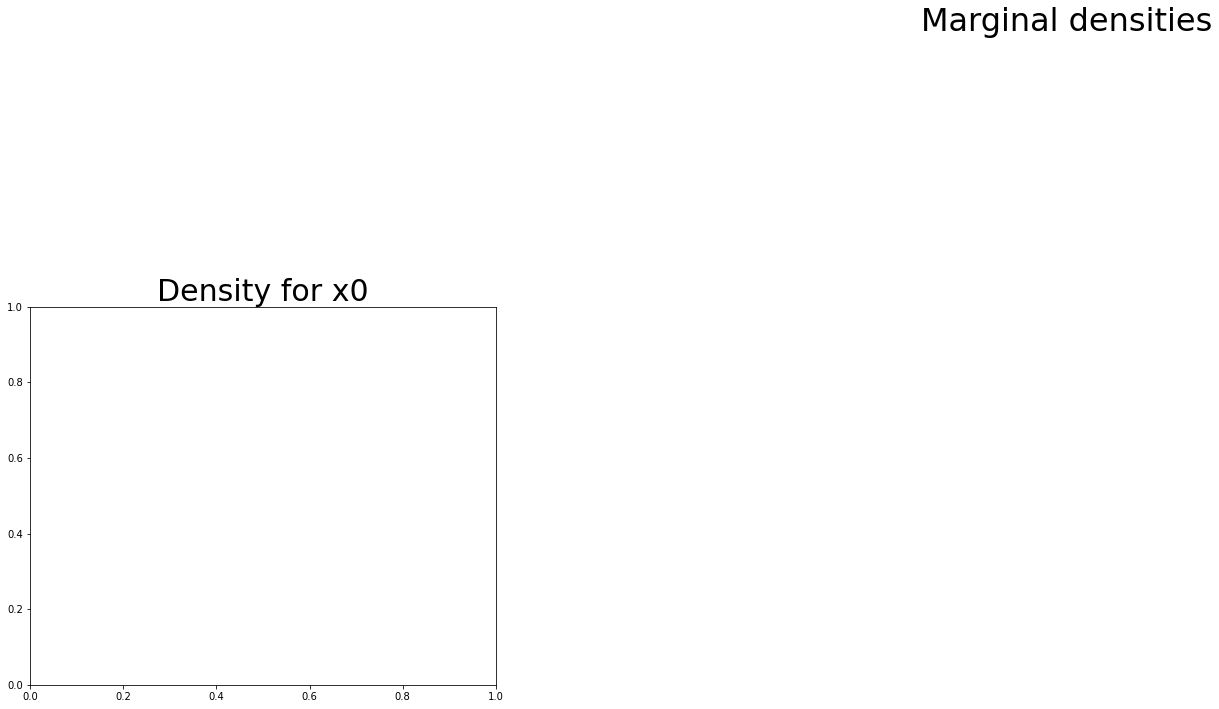

In [193]:
plt.figure(figsize=(4*1.5*6.4,4*8))
plt.subplot(4, 4, 1)
plt.suptitle(f'Marginal densities', y=1.01, fontsize=title_fs)
for dim in range(bp.A.shape[1]):
    plt.subplot(4, 4, dim+1)
    plt.title(f'Density for x{dim}', fontsize=title_fs-2)
    _, bins, _ = plt.hist(np.concatenate(samples['Billiard walk'], axis=0)[:, dim], bins=100, density=True, label='Multiphase Billiard Walk' if dim == 0 else None, alpha=0.75, color='C0')
    # _ = plt.hist(np.concatenate(samples['CHRR'], axis=0)[:, dim], bins=bins, alpha=0.5, density=True, label='CHRR' if dim == 0 else None, color='C1')
    _ = plt.hist(np.concatenate(samples['CHRRT'], axis=0)[:, dim], bins=bins, alpha=0.25, density=True, label='CHRRT' if dim == 0 else None, color='C1')
    _ = plt.hist(np.concatenate(samples['OHRR'], axis=0)[:, dim], bins=bins, alpha=0.25, density=True, label='OHRR' if dim == 0 else None, color='C2')
    # plt.ylabel(r'$s$', fontsize=label_fs)
    # plt.xlabel(r'Benchmark Problem', fontsize=label_fs)
    plt.xticks(fontsize=tick_fs)
    plt.yticks(fontsize=tick_fs)

# plt.grid()

plt.tight_layout()

plt.figlegend(fontsize=legend_fs)
plt.tight_layout()
plt.show()